<a href="https://colab.research.google.com/github/123ranika/Research-paper/blob/main/1_BERT_Multi_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [2]:
!pip install transformers

## Importing necessary packages

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [4]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading training data

In [6]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_csv('/content/Traning.xlsx - Sheet1 (7).csv')

# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'text', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 6,000

       PID                                               text  \
1782  1783                       নিচ মানসিকতার ধিক্কার জানাই।   
3917  3918              খানকির পোলা তোরে আমি খুঁজে বেড়াইতাছি   
221    222                                  দাতের ড্রেইন নাকি   
2135  2136                                       ছেলে তো কালা   
5224  5225           হাসিনা ক্ষমতার লোভে সবকিছু ধ্বংস করে দিল   
1168  1169  বেয়াদবের মতো না জেনে শেষের মেয়েটার ভিডিও এড ...   
879    880             গ্রামের মহিলাদের মতো বাজে মহিলা দেখিনি   
156    157                   লিঙ্গবৈষম্য মানে অজ্ঞতার পরিচয়।   
1657  1658    উনার স্বামী এই মুভি দেখে গর্বে গর্ববতী হয়ে গেছে   
323    324               সীমালংঘনকারীদের আল্লাহ পছন্দ করেন না   

                     labels  
1782          Cyberbullying  
3917          Cyberbullying  
221                 Sarcasm  
2135                 Racism  
5224              Political  
1168          Cyberbullying  
879   Gender_Discrimination  
156   G

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [8]:
train_df

,PID,text,labels
3897,3898,এমন মজবুত রশি কই পাওয়া যায় ভাই,Sarcasm
5628,5629,মাদা রের বাচ্চা তুমার মত মাগী দের কপালে জুতার ...,Cyberbullying
1756,1757,কিরে রনি তুই কি মাহির ও ছাত্র হওয়ার যোগ্যতা রা...,Gender_Discrimination
2346,2347,রান করতে পারে না উনি আইছে দায়িত্ব নিতে,Racism
2996,2997,হাঙ্গা পড়াইতাছে হুজুরের সাথে।,Religious_Hatred
...,...,...,...
3772,3773,ছাগল গোলার সঙ্গে বিডিও করে,Cyberbullying
5191,5192,পাশে ঘুমটার ভিতরে ছেলে মনে হচ্ছে,Gender_Discrimination
5226,5227,শুয়োরের বাচচাটা কবে হবে পেট মোটাতা,Cyberbullying
5390,5391,ভাইরে নল ঢুকানোটা ভুল,Sarcasm


In [9]:
test_df

,PID,text,labels
5000,5001,এদের তো চামড়া ব্যবসায়ী,Racism
5492,5493,দ্বিতীয় মুক্তিযুদ্ধের রিহার্সেল,Political
439,440,বালটিউবারসহ ৩ চুদিরপুত এক জায়গায়,Cyberbullying
4834,4835,আপ কাছাকাছি আছে সাবধান,Religious_Hatred
1225,1226,বাংলাদেশ বিনোদনের কারখানা,Sarcasm
...,...,...,...
1086,1087,চোদানি ম*** একটা আলগা সোনা কিনে নিস.,Cyberbullying
5488,5489,এই জন্যই তোরা মালাউন জাতি পরের ভালো সহ্য হয়না ...,Racism
776,777,চুমা দেওয়ার পোলাডারে ঢাক দিমুনি।,Cyberbullying
4190,4191,বিসিবির সমস্ত পদবী পরিবর্তন করতে হবে।,Political


In [10]:
val_df

,PID,text,labels
5160,5161,কিস টা করছে সিরিয়াসলি নিজের আপন বউ ভেবে,Cyberbullying
2845,2846,"সহ বাশ,,আইক্কা ওলা বাঁশ",Sarcasm
1870,1871,রাতে অনেক মজা দিবো,Cyberbullying
3606,3607,চুদে চাটনি বেকার খাটনি,Cyberbullying
1074,1075,তোমাদের এই গুয়ার বিডিও পুটকিত দেও ।,Cyberbullying
...,...,...,...
426,427,মামুন ছিলো টিকটক যুদ্ধা,Cyberbullying
2864,2865,যদি থাকে গর্ত উপার্জন করা যায় অর্থ,Sarcasm
1501,1502,ছাপড়ি বইন আমার,Cyberbullying
4915,4916,চুমা দে চুচুচু দিদিদি ররর ভাই😎,Cyberbullying


In [11]:
train_df['labels'].value_counts()

,count
labels,
Cyberbullying,1341
Sarcasm,1213
Political,630
Gender_Discrimination,551
Religious_Hatred,548
Racism,517


In [12]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [13]:
train_df['labels'].value_counts()

,count
labels,
0,1341
5,1213
2,630
1,551
4,548
3,517


### Loading `train_sentences` and `train_labels`

In [14]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [15]:
class_names = [
               'Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'
]


## Loading the validation data

In [16]:
val_df['labels'] = le.transform(val_df['labels'])

In [17]:

val_df['labels'].value_counts()

,count
labels,
0,183
5,137
3,86
1,70
2,65
4,59


### Loading `val_sentences` and `val_labels`

In [18]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

In [19]:
val_labels

array([0, 5, 0, 0, 0, 4, 0, 2, 0, 5, 5, 3, 0, 5, 2, 5, 0, 0, 1, 5, 1, 3,
       0, 4, 2, 5, 5, 2, 0, 5, 0, 3, 5, 2, 0, 3, 1, 2, 0, 1, 1, 3, 3, 4,
       2, 0, 1, 3, 2, 1, 0, 3, 3, 1, 1, 0, 2, 5, 2, 0, 5, 2, 0, 1, 5, 3,
       0, 5, 3, 0, 5, 0, 0, 0, 5, 5, 5, 3, 1, 5, 0, 4, 5, 0, 3, 5, 5, 0,
       3, 3, 3, 3, 0, 3, 1, 5, 0, 1, 5, 2, 4, 0, 3, 4, 2, 4, 4, 0, 3, 5,
       3, 1, 0, 1, 1, 2, 1, 0, 0, 4, 5, 0, 5, 3, 1, 0, 4, 5, 1, 3, 5, 0,
       3, 2, 0, 3, 2, 2, 0, 5, 4, 4, 2, 0, 3, 3, 1, 0, 4, 4, 3, 3, 3, 0,
       2, 5, 4, 0, 4, 0, 0, 0, 3, 0, 4, 4, 0, 0, 5, 1, 5, 5, 3, 4, 2, 0,
       1, 4, 0, 4, 3, 3, 0, 2, 5, 0, 5, 5, 0, 2, 0, 0, 0, 2, 1, 1, 4, 2,
       2, 0, 2, 3, 5, 1, 0, 3, 4, 5, 0, 0, 5, 0, 1, 0, 2, 0, 3, 4, 1, 0,
       3, 0, 5, 2, 4, 5, 0, 4, 1, 4, 0, 5, 2, 1, 5, 0, 0, 4, 5, 0, 1, 1,
       2, 5, 5, 5, 3, 4, 3, 1, 1, 0, 2, 0, 3, 0, 0, 0, 5, 5, 4, 5, 5, 3,
       4, 2, 4, 3, 1, 0, 0, 3, 4, 0, 5, 1, 2, 5, 4, 5, 5, 3, 3, 5, 0, 5,
       0, 0, 0, 0, 3, 5, 1, 0, 4, 0, 5, 0, 1, 5, 2,

## Helper Functions

#### 1) Update Interval Function

In [20]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [22]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [23]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [24]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [25]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [26]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [27]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [28]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [29]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [30]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [31]:
model_name = 'sagorsarker/bangla-bert-base'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading sagorsarker/bangla-bert-base tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [32]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

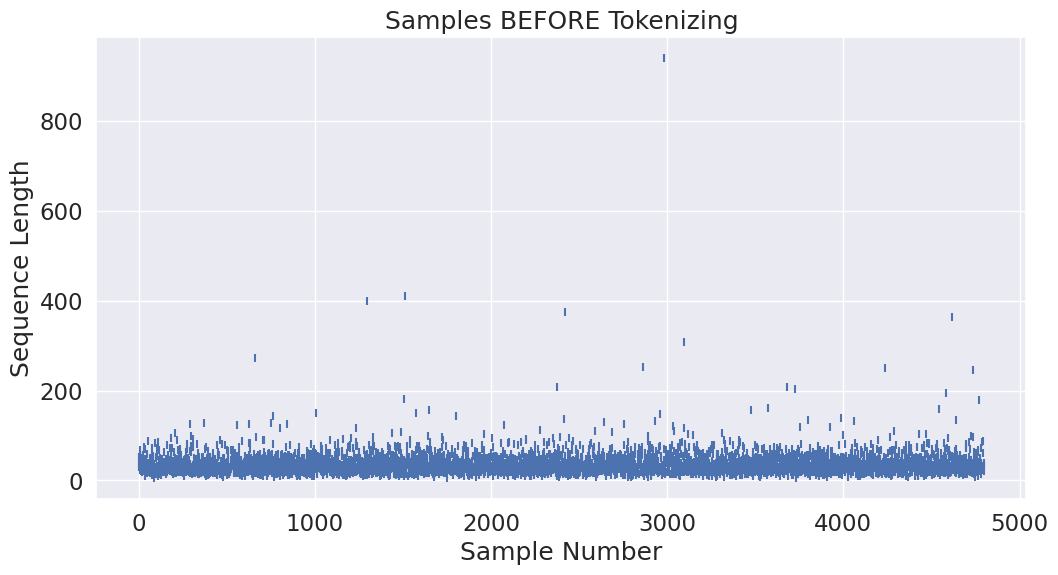

In [33]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [34]:
max_input_length = 300

In [35]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 4,800 training samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
DONE.
     4,800 samples


In [36]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

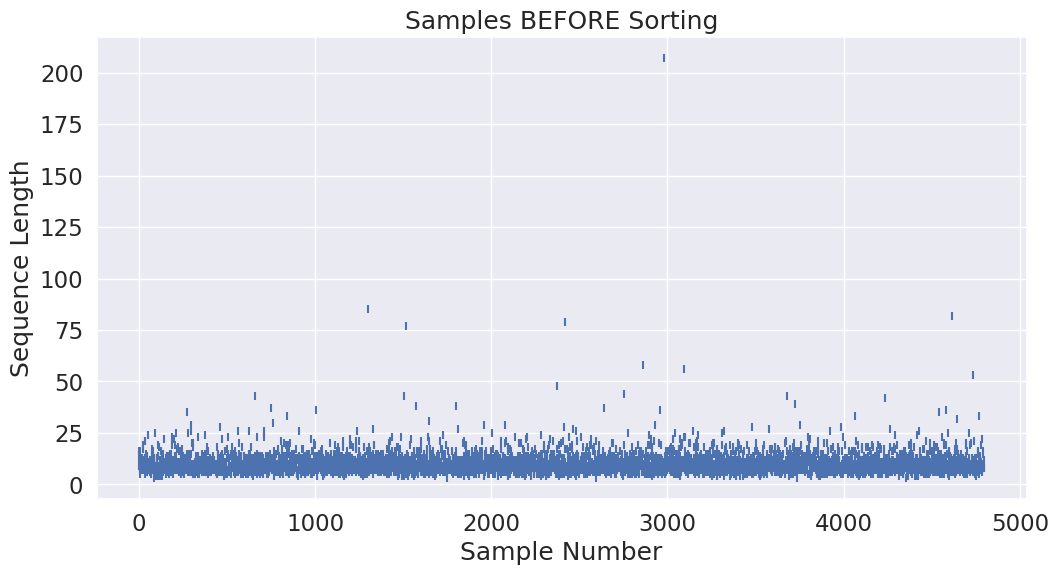

In [37]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [38]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [39]:
train_samples[0:5]

[([101, 100, 102], 0),
 ([101, 46214, 102], 0),
 ([101, 13401, 102], 0),
 ([101, 12336, 102], 0),
 ([101, 100, 102], 0)]

In [40]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 207


In [41]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

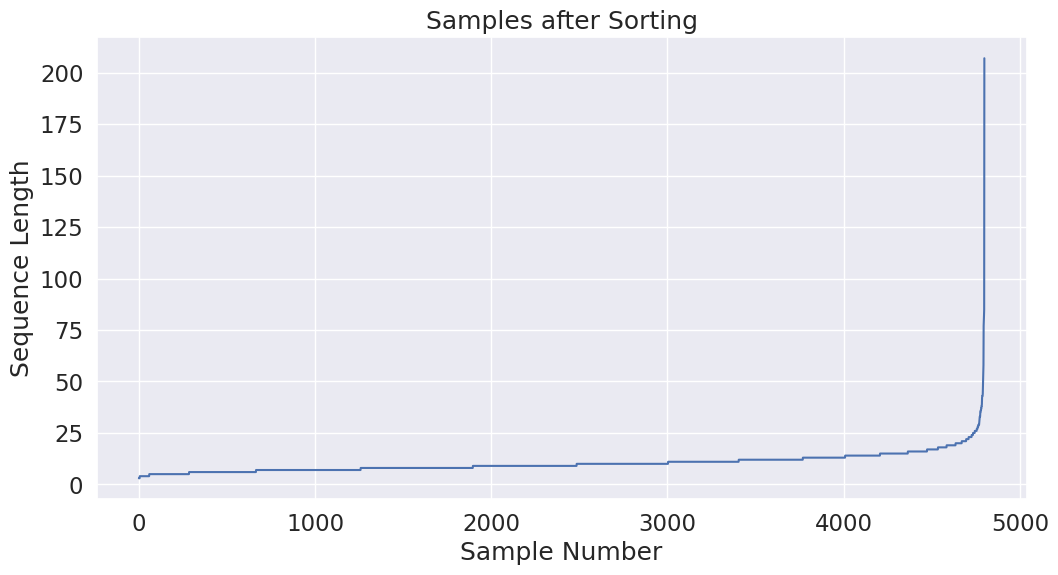

In [42]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [43]:
train_samples[0]

([101, 100, 102], 0)

In [44]:
batch_size = 16

In [45]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.

  DONE - 300 batches.


In [46]:
print(batch_ordered_sentences[0])

[[101, 2127, 2304, 13394, 61976, 2392, 102], [101, 2197, 2191, 2070, 2178, 17250, 102], [101, 32474, 2178, 2183, 55866, 3867, 102], [101, 7536, 31143, 3347, 2178, 2274, 102], [101, 2132, 62615, 8420, 59169, 5104, 102], [101, 2150, 2100, 2184, 13401, 2086, 102], [101, 2936, 2392, 2178, 4820, 3223, 102], [101, 7371, 26607, 2196, 3999, 6457, 102], [101, 2045, 5136, 2285, 22937, 20117, 102], [101, 2092, 4503, 100, 6728, 1014, 102], [101, 2410, 100, 14688, 100, 3304, 102], [101, 16756, 3035, 31173, 3187, 5663, 102], [101, 15399, 3878, 2829, 2047, 2054, 102], [101, 21103, 49445, 3882, 5072, 7144, 102], [101, 2070, 2169, 38537, 2765, 30832, 102], [101, 9699, 4999, 3696, 23240, 2170, 102]]


In [47]:
batch_ordered_labels[0]

[5, 5, 5, 5, 0, 2, 5, 0, 3, 3, 2, 5, 5, 5, 0, 0]

### Padding

In [48]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [49]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 1,440,000
  Smart Batching: 54,976  (96.2% less)


## Load the model configuration from the transformers library using AutoConfig

In [50]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [51]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Load the model from the transformers library using AutoModel

In [53]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [54]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [55]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [56]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [57]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [58]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [59]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [60]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [61]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 5 ========
Training on 300 batches...
  Batch      30 of     300. Elapsed: 0:00:05. Remaining: 0:00:46
  Batch      60 of     300. Elapsed: 0:00:08. Remaining: 0:00:32
  Batch      90 of     300. Elapsed: 0:00:10. Remaining: 0:00:24
  Batch     120 of     300. Elapsed: 0:00:14. Remaining: 0:00:22
  Batch     150 of     300. Elapsed: 0:00:18. Remaining: 0:00:18
  Batch     180 of     300. Elapsed: 0:00:20. Remaining: 0:00:14
  Batch     210 of     300. Elapsed: 0:00:23. Remaining: 0:00:10
  Batch     240 of     300. Elapsed: 0:00:25. Remaining: 0:00:06
  Batch     270 of     300. Elapsed: 0:00:28. Remaining: 0:00:03
  Average training loss: 1.25
  Training Accuracy: 0.52
  Training epoch took: 0:00:32
Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokeni

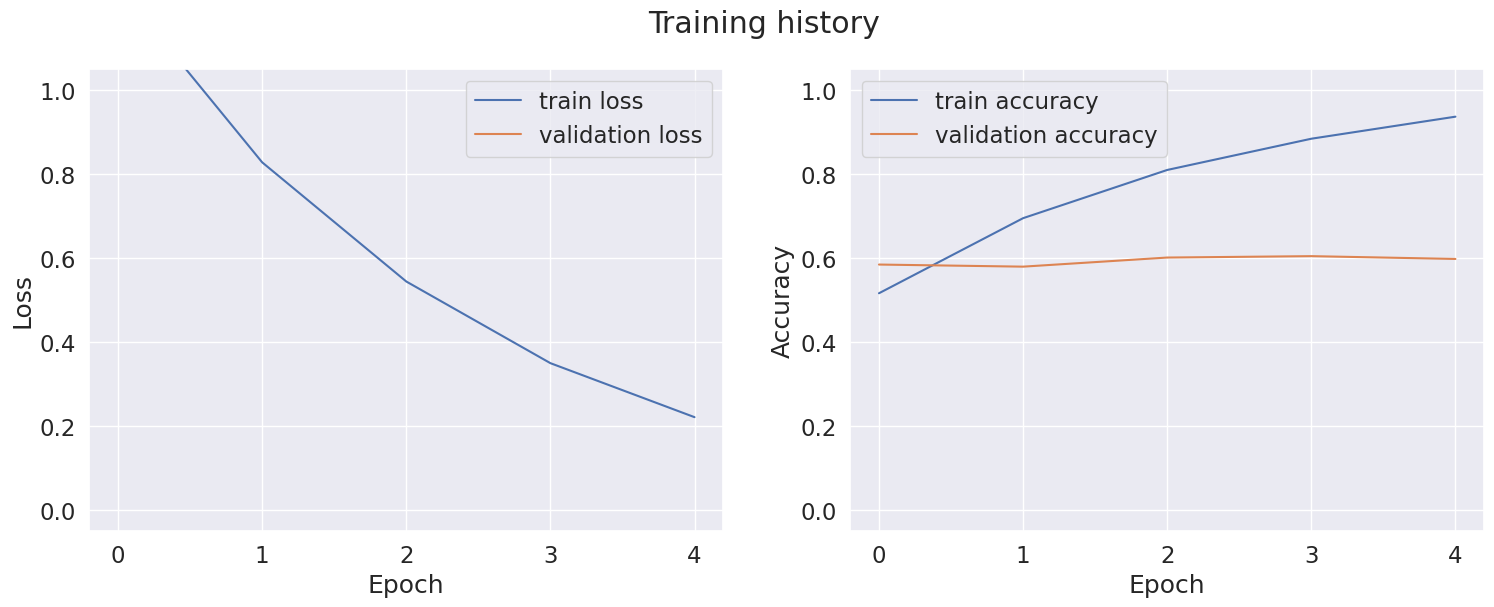

In [62]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [63]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 4,800 examples with batch size 16...

Tokenizing 4,800 samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
DONE.
     4,800 samples

     4,800 samples after sorting

Creating batches of size 16...

  DONE - Selected 300 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 300 test batches...
  Batch      30  of      300.    Elapsed: 0:00:00.  Remaining: 0:00:03
  Batch      60  of      300.    Elapsed: 0:00:01.  Remaining: 0:00:03
  Batch      90  of      300.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch     120  of      300.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch     150  of      300.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch     180  of      300.    Elapsed: 0:00:02.  Remaining: 0:00:01

In [64]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.97      0.97      0.97      1341
     Religious_Hatred       0.96      0.94      0.95       551
Gender_Discrimination       0.98      0.99      0.99       630
              Sarcasm       0.97      0.95      0.96       517
            Political       0.98      0.98      0.98       548
               Racism       0.97      0.98      0.97      1213

             accuracy                           0.97      4800
            macro avg       0.97      0.97      0.97      4800
         weighted avg       0.97      0.97      0.97      4800



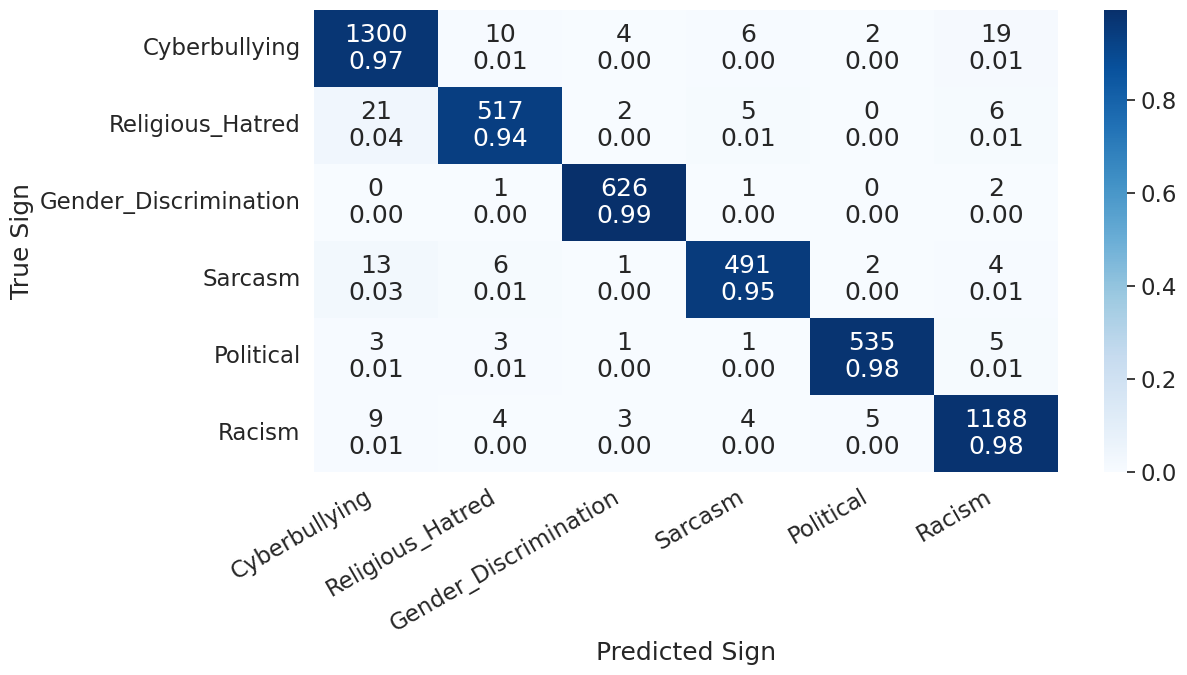

In [65]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [66]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       600 samples

       600 samples after sorting

Creating batches of size 16...

  DONE - Selected 38 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of   

In [67]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.54      0.54      0.54       183
     Religious_Hatred       0.55      0.49      0.52        70
Gender_Discrimination       0.63      0.69      0.66        65
              Sarcasm       0.65      0.57      0.61        86
            Political       0.80      0.81      0.81        59
               Racism       0.56      0.62      0.59       137

             accuracy                           0.60       600
            macro avg       0.62      0.62      0.62       600
         weighted avg       0.60      0.60      0.60       600



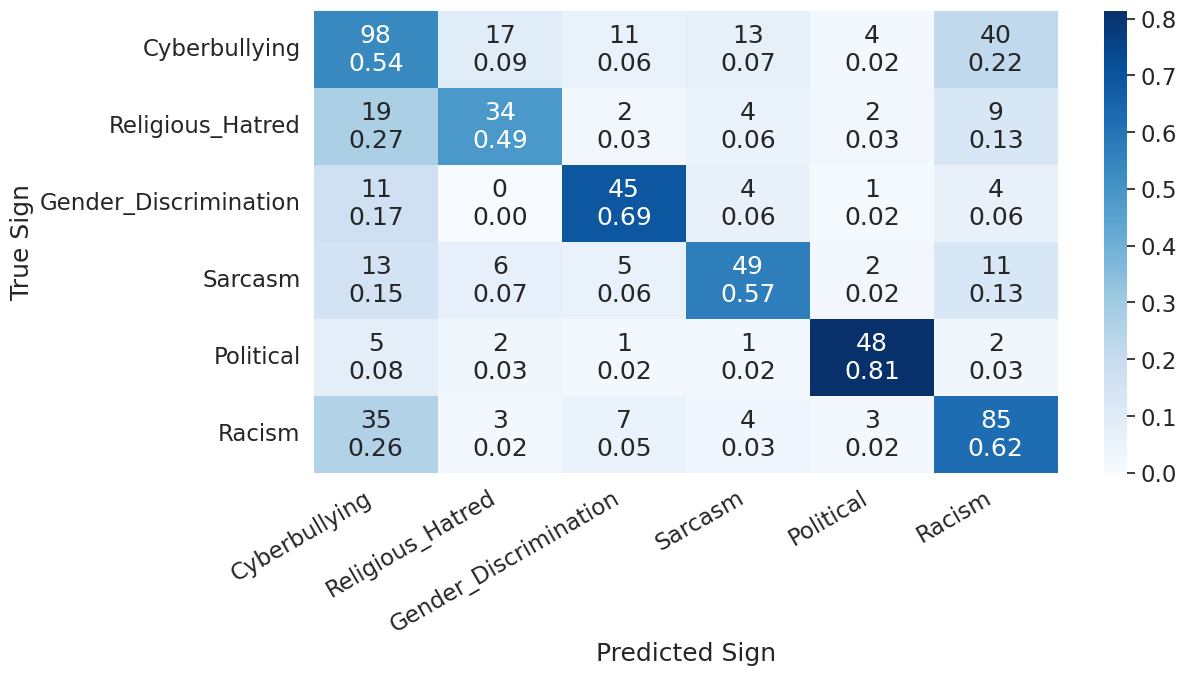

In [68]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [69]:
test_df

,PID,text,labels
5000,5001,এদের তো চামড়া ব্যবসায়ী,Racism
5492,5493,দ্বিতীয় মুক্তিযুদ্ধের রিহার্সেল,Political
439,440,বালটিউবারসহ ৩ চুদিরপুত এক জায়গায়,Cyberbullying
4834,4835,আপ কাছাকাছি আছে সাবধান,Religious_Hatred
1225,1226,বাংলাদেশ বিনোদনের কারখানা,Sarcasm
...,...,...,...
1086,1087,চোদানি ম*** একটা আলগা সোনা কিনে নিস.,Cyberbullying
5488,5489,এই জন্যই তোরা মালাউন জাতি পরের ভালো সহ্য হয়না ...,Racism
776,777,চুমা দেওয়ার পোলাডারে ঢাক দিমুনি।,Cyberbullying
4190,4191,বিসিবির সমস্ত পদবী পরিবর্তন করতে হবে।,Political


## Loading `test_sentences`

In [70]:
test_sentences = test_df['text'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [71]:
test_ids

array([5000, 5492,  439, 4834, 1225,  183,  681, 4480, 2244,  381, 4879,
       2031, 4071, 3053, 5992, 3193, 5563, 5294, 4999, 3647, 1964, 3958,
       4369, 4866, 1176,  351, 2080, 5050, 1671,  622, 3867,  292, 3185,
       4724, 4557, 3184, 2977,  996, 1194,  445, 4762, 1039, 5317, 5368,
       5693, 1891, 5112, 3720, 3035, 1487, 4301, 4458,   69, 2892, 5510,
       2127,  199, 2357, 3469, 4939, 1864, 1535, 4756,  319,  549, 5118,
       5591, 2024, 5823, 5606, 5892, 1505, 3033, 4674, 3544,  245, 1978,
       4046, 2617, 5851,  748,  476, 1564,  124, 5527, 2834, 3484, 3090,
       4020, 3892, 4568, 2313, 1905, 4196,   93, 3459, 2602, 1161, 2788,
       5098,  371, 2163,  185, 5047, 2611, 3094, 2086, 4010,  228,  296,
       1407, 2476, 4310,  584, 2584,  752, 4353, 5846, 5525, 1817, 2957,
       3045, 5297, 2142, 1729, 1374, 2638, 1533, 3971, 4581, 3407, 3937,
       5556, 5808,   23, 3859, 3707, 5217, 3764, 4379, 3130, 4876, 3226,
        501, 2767, 3734, 4603, 5026, 2663, 5683,  3

In [72]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       600 samples

       600 samples after sorting

Creating batches of size 16...

  DONE - Selected 38 batches.

Padding out sequences within each batch...
  DONE.


In [73]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      32  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      36  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00


In [74]:
test_sentences

array(['এদের তো চামড়া ব্যবসায়ী', 'দ্বিতীয় মুক্তিযুদ্ধের রিহার্সেল',
       'বালটিউবারসহ ৩ চুদিরপুত এক জায়গায়', 'আপ কাছাকাছি আছে সাবধান',
       'বাংলাদেশ বিনোদনের কারখানা', 'সাজু খাদেম আসলেই একটা বেয়াদব',
       'আপু কাপড় চোপর খুলে ভিডিও বানালে আরো বেশি বিউ হবে!',
       'নারীদের অবদানের কদর না করলে, সমাজ পিছিয়ে পড়বে।',
       'ভেলা হয়ে যাবে', 'সিনারে বিয়া করমু নি কি বলো',
       'প্রিয় জনি সিনং আক্কেল', 'তুই একটা শালা গরুর বাচ্চা।',
       'কুকুরের ভ্যাকসিন টাও নিয়ে আসবে',
       'কুকুর নিয়ে এত টানাটানি করে লাভ নাই',
       'জামাত শিবির বিলুপ্ত হলেও পৃথিবীতে এদের মুখে বেঁচে থাকবে সারা জীবন।',
       'তোর হিন্দু বন্ধুদের বান্ধবীদের নিয়া বৃন্দাবনে গিয়া লিলা করগা',
       'লিঙ্গবৈষম্য শুধু মূর্খদের কাজ।',
       'জীবন পাপ করলে একাটাই পাপ করচি কেন যে ফেসবুক আইডি খুল্লাম',
       'আরে নিগা তোর ফটোই যথেষ্ট শোক দিবস পালনের জন্য',
       'শেষ পর্যন্ত নবী (সাঃ) এর সাথে বেইমানী করা শুরু করছেন।',
       'ধূর ব্যাটা, এইডা কিছু হইলো ব্যাটা?', 'খনিকের পুলারা আমরা খাইলেই',
       'সল্পপুজি দিয়

In [75]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       600 samples

       600 samples after sorting

Creating batches of size 16...

  DONE - Selected 38 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of   

In [76]:
y_pred

array([3, 5, 5, 5, 2, 1, 0, 5, 5, 5, 5, 4, 0, 0, 5, 0, 3, 5, 0, 1, 5, 2,
       1, 5, 3, 0, 3, 0, 1, 5, 5, 1, 0, 4, 3, 3, 3, 3, 0, 5, 4, 1, 4, 3,
       0, 0, 4, 0, 2, 5, 5, 0, 1, 4, 2, 2, 0, 4, 5, 2, 5, 2, 5, 3, 5, 1,
       2, 2, 2, 5, 0, 3, 4, 0, 0, 5, 0, 5, 0, 5, 5, 1, 0, 2, 4, 0, 4, 0,
       1, 3, 1, 2, 0, 3, 0, 0, 5, 4, 0, 5, 3, 2, 1, 1, 2, 0, 5, 5, 5, 4,
       4, 5, 2, 5, 0, 0, 5, 3, 0, 0, 0, 5, 1, 0, 0, 2, 5, 1, 5, 0, 3, 0,
       5, 5, 5, 1, 0, 0, 0, 1, 0, 4, 5, 5, 5, 0, 5, 0, 3, 5, 2, 5, 0, 2,
       5, 5, 5, 5, 3, 5, 4, 0, 0, 1, 5, 5, 2, 5, 2, 5, 5, 5, 5, 0, 5, 0,
       5, 0, 0, 3, 0, 4, 0, 4, 3, 0, 5, 4, 2, 2, 0, 5, 2, 3, 0, 0, 5, 0,
       3, 4, 3, 5, 0, 2, 2, 0, 5, 0, 5, 2, 2, 0, 5, 2, 0, 5, 5, 5, 1, 0,
       0, 3, 2, 0, 0, 4, 5, 4, 0, 0, 2, 5, 0, 4, 3, 0, 0, 1, 0, 4, 2, 5,
       0, 5, 1, 0, 1, 4, 0, 2, 5, 5, 4, 4, 0, 3, 2, 0, 2, 4, 4, 0, 4, 0,
       5, 1, 5, 0, 5, 0, 3, 2, 5, 2, 5, 1, 2, 5, 0, 1, 5, 2, 5, 5, 5, 2,
       5, 3, 0, 1, 5, 2, 4, 5, 4, 0, 0, 0, 2, 0, 5,

## Evaluating accuracy over test set

In [77]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      32  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      36  of       38.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [78]:
print(y_preds)

[3 5 5 5 2 1 0 5 5 5 5 4 0 0 5 0 3 5 0 1 5 2 1 5 3 0 3 0 1 5 5 1 0 4 3 3 3
 3 0 5 4 1 4 3 0 0 4 0 2 5 5 0 1 4 2 2 0 4 5 2 5 2 5 3 5 1 2 2 2 5 0 3 4 0
 0 5 0 5 0 5 5 1 0 2 4 0 4 0 1 3 1 2 0 3 0 0 5 4 0 5 3 2 1 1 2 0 5 5 5 4 4
 5 2 5 0 0 5 3 0 0 0 5 1 0 0 2 5 1 5 0 3 0 5 5 5 1 0 0 0 1 0 4 5 5 5 0 5 0
 3 5 2 5 0 2 5 5 5 5 3 5 4 0 0 1 5 5 2 5 2 5 5 5 5 0 5 0 5 0 0 3 0 4 0 4 3
 0 5 4 2 2 0 5 2 3 0 0 5 0 3 4 3 5 0 2 2 0 5 0 5 2 2 0 5 2 0 5 5 5 1 0 0 3
 2 0 0 4 5 4 0 0 2 5 0 4 3 0 0 1 0 4 2 5 0 5 1 0 1 4 0 2 5 5 4 4 0 3 2 0 2
 4 4 0 4 0 5 1 5 0 5 0 3 2 5 2 5 1 2 5 0 1 5 2 5 5 5 2 5 3 0 1 5 2 4 5 4 0
 0 0 2 0 5 4 4 0 5 2 5 0 3 2 2 0 2 4 0 0 0 1 4 4 2 0 0 1 0 0 5 5 5 2 5 0 1
 3 0 0 5 5 0 0 2 1 1 3 5 0 3 1 2 0 4 1 4 5 5 0 0 0 0 0 5 4 1 4 0 2 5 0 2 2
 1 3 5 0 5 4 5 3 5 4 0 4 0 2 2 5 4 1 0 0 2 0 3 0 3 4 2 2 0 5 5 4 5 2 2 5 5
 0 0 0 0 3 0 5 0 5 2 5 1 4 1 4 0 5 5 0 0 3 4 2 5 0 3 0 5 5 3 5 5 0 3 0 5 2
 0 5 0 3 5 5 3 3 4 1 0 4 4 2 4 3 5 5 0 4 2 5 2 3 3 0 0 2 4 5 0 3 1 0 2 4 5
 4 5 0 5 2 5 0 4 5 2 1 5 

In [79]:
print(y_ids)

[1559 2516  746 2968 4796  183 4879 3185 4762 5510  199 3469 4756 4046
 3090 3892 1158 1438  655 5495 1315 1694 3751 5684 3700 4280 2031 4071
 5563 4369  292 4724 5400  228 5556 3550 3392 3795 1566 4629 3971 4258
 4686 3937 3226 3182 5638 3916 4102 2436 2650 5639 1755 4275  473 1253
 4594  977 1499 1966 5364 3320 5787 2819  683  422 1859 3240 4698 1186
 1657 1204  960 2115 3967 1047 1142 4733 3525 4250 3938  167 1049   15
 4650 4758 3805 4738 3487 2802 2287 3372 2002 4930 2704   29 5368 3720
 3033  245 2617 4568 2086 1374 2638 4876 4620 1370 2503  239 5800 3664
  319  124 1817 2142 1729 5217 2663 3382 5314 3973 1383 2945 1042 4714
 5648 4607 4454  437 3529 2913 2770 5322 3856 5404 4742  168 5948  110
  393 5693 1864 3149 3158 4472  747 4476 1354 5708 2227 2432  177 1562
 1669 5692  691 4635 1536 2022 4886 5164  297  452 2077 1357  346 3607
 3026 1075 2323 2549 1773 4103 4383 5000 3135 5395 1086 5488 4999 2024
  505  414 2900 1873 5294 3647  308 4526 3799 2846 3012 3309 3285 5959
 1219 

In [80]:
le.inverse_transform(y_preds)

array(['Racism', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Political',
       'Gender_Discrimination', 'Cyberbullying', 'Sarcasm', 'Sarcasm',
       'Sarcasm', 'Sarcasm', 'Religious_Hatred', 'Cyberbullying',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Racism', 'Sarcasm',
       'Cyberbullying', 'Gender_Discrimination', 'Sarcasm', 'Political',
       'Gender_Discrimination', 'Sarcasm', 'Racism', 'Cyberbullying',
       'Racism', 'Cyberbullying', 'Gender_Discrimination', 'Sarcasm',
       'Sarcasm', 'Gender_Discrimination', 'Cyberbullying',
       'Religious_Hatred', 'Racism', 'Racism', 'Racism', 'Racism',
       'Cyberbullying', 'Sarcasm', 'Religious_Hatred',
       'Gender_Discrimination', 'Religious_Hatred', 'Racism',
       'Cyberbullying', 'Cyberbullying', 'Religious_Hatred',
       'Cyberbullying', 'Political', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Gender_Discrimination', 'Religious_Hatred',
       'Political', 'Political', 'Cyberbullying', 'Religious_Hatred',
       'Sar

<Axes: xlabel='count'>

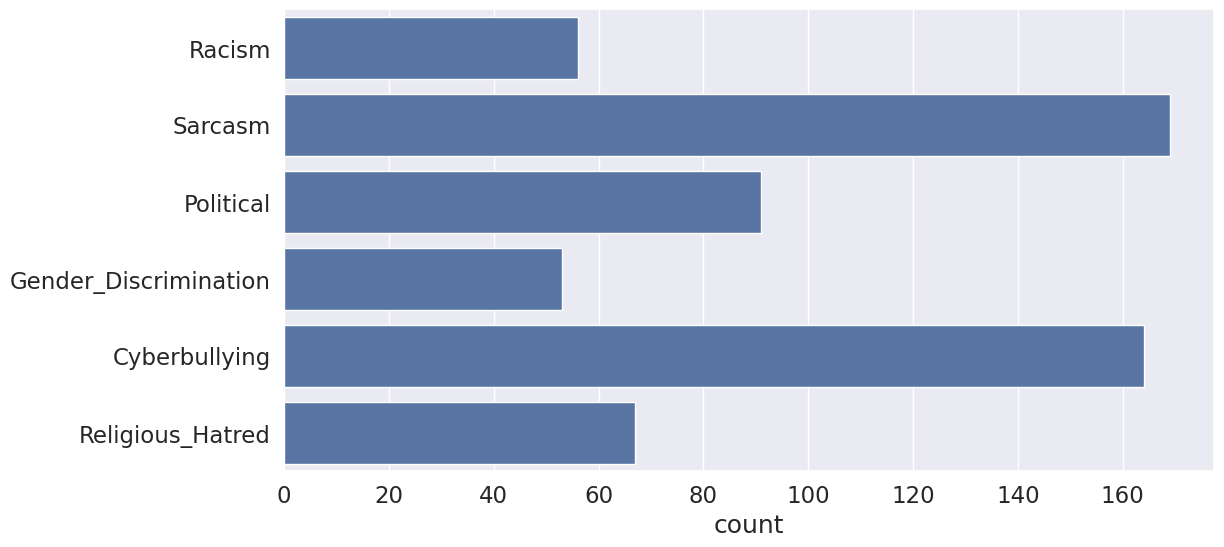

In [81]:
sns.countplot(y =le.inverse_transform(y_preds))

In [82]:
len(y_ids)

600

In [83]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['Racism', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Political',
       'Gender_Discrimination', 'Cyberbullying', 'Sarcasm', 'Sarcasm',
       'Sarcasm', 'Sarcasm', 'Religious_Hatred', 'Cyberbullying',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Racism', 'Sarcasm',
       'Cyberbullying', 'Gender_Discrimination', 'Sarcasm', 'Political',
       'Gender_Discrimination', 'Sarcasm', 'Racism', 'Cyberbullying',
       'Racism', 'Cyberbullying', 'Gender_Discrimination', 'Sarcasm',
       'Sarcasm', 'Gender_Discrimination', 'Cyberbullying',
       'Religious_Hatred', 'Racism', 'Racism', 'Racism', 'Racism',
       'Cyberbullying', 'Sarcasm', 'Religious_Hatred',
       'Gender_Discrimination', 'Religious_Hatred', 'Racism',
       'Cyberbullying', 'Cyberbullying', 'Religious_Hatred',
       'Cyberbullying', 'Political', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Gender_Discrimination', 'Religious_Hatred',
       'Political', 'Political', 'Cyberbullying', 'Religious_Hatred',
       'Sar

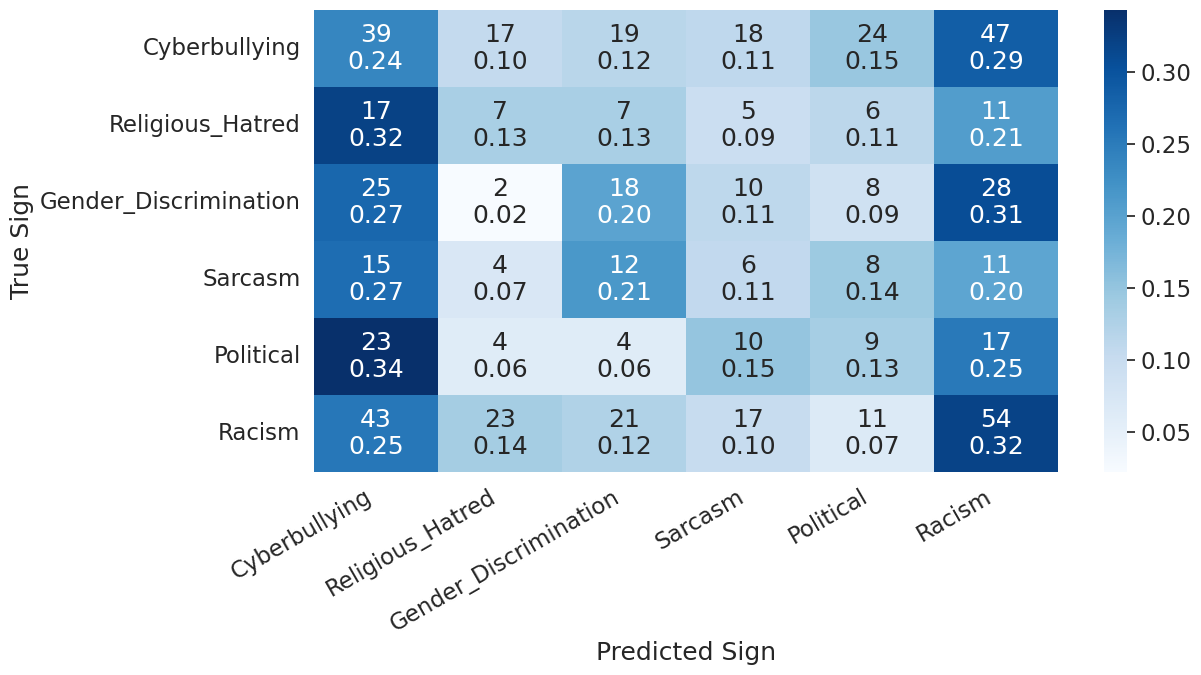

In [84]:
cm = confusion_matrix(y_pred, test_labels)
show_confusion_matrix(cm, class_names)

Classification Report:
                       precision    recall  f1-score   support

        Cyberbullying     0.2378    0.2407    0.2393       162
     Religious_Hatred     0.1321    0.1228    0.1273        57
Gender_Discrimination     0.1978    0.2222    0.2093        81
              Sarcasm     0.1071    0.0909    0.0984        66
            Political     0.1343    0.1364    0.1353        66
               Racism     0.3195    0.3214    0.3205       168

             accuracy                         0.2217       600
            macro avg     0.1881    0.1891    0.1883       600
         weighted avg     0.2195    0.2217    0.2204       600



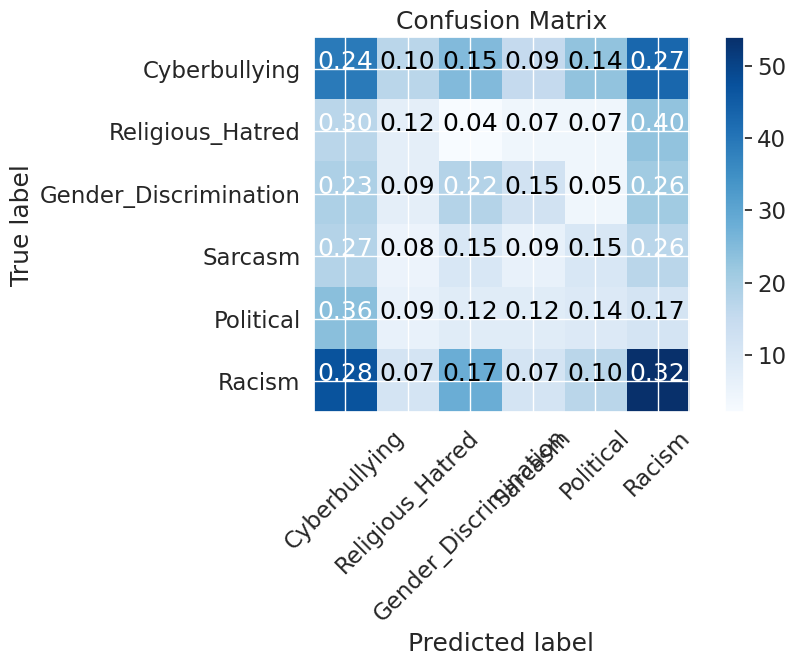

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_pred and test_labels are defined
# Convert predictions to class labels if they are probabilities (if needed)
# y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=class_names, zero_division=0, digits=4))

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Function to display the confusion matrix
def show_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrix
show_confusion_matrix(cm, class_names)
